In [1]:
import numpy as np
from scipy.signal import welch
import matplotlib.pylab as plt
import seaborn as sns
from copy import deepcopy

In [2]:
def computePhases(timesteps, time_to_freq, K=1, N=500, sigma=1):
    phi_initial = np.random.uniform(-np.pi, np.pi, size=N)
    
    phases = np.zeros((len(timesteps), N))
    phases[0, :] = phi_initial
    t_start = timesteps[0]
    for idx, ts in list(enumerate(timesteps))[1:]:
        freq = time_to_freq(ts)
        freq = np.random.uniform(0.75 * freq, 1.25 * freq, size=N)
        first = 2 * np.pi * freq
        
        sin_delta = np.sin(deepcopy(phases[idx - 1, :]) - phases[idx - 1, :][np.newaxis, :])
        second = K / N * np.sum(sin_delta, axis=1)
        
        noise = np.random.normal(0, sigma)
        
        phases[idx, :] = phases[idx - 1, :] + (timesteps[idx] - timesteps[idx - 1]) * (first + second + noise)
    return phases


def computeSignal(phases):
    complex_signal = np.exp(1j * phases)
    model_signal = complex_signal.mean(axis=1)
    return model_signal.real

In [3]:
def simulation(func, timesteps, dt, freq_list, K, N, sigma):
    signal_list = []
    psd_list = []
    fs_list = []
    phase_list = []
    
    for freq in freq_list:
        time_to_freq = func(freq)
        phases = computePhases(timesteps, time_to_freq, K, N, sigma)
        signal = computeSignal(phases)
        fs, psd = welch(signal, fs=int(1/dt), scaling='spectrum')
        signal_list.append(signal)
        psd_list.append(psd)
        fs_list.append(fs)
        phase_list.append(phases)
        
    return signal_list, psd_list, fs_list, phase_list

In [4]:
dt = 0.01
t_start = 0.0
t_finish = 60.0

K = 1.5
N = 500
sigma = 1

f_10 = [10] * 10
f_15 = [15] * 5
f_25 = [25] * 5
freq_list1 = f_10 + f_15 + f_25
timesteps = np.arange(t_start, t_finish, dt)

In [5]:
def func1(freq):
    return lambda ts: freq

signal_list1, psd_list1, fs_list1, phase_list1 = simulation(func1, timesteps, dt, freq_list1, K, N, sigma)

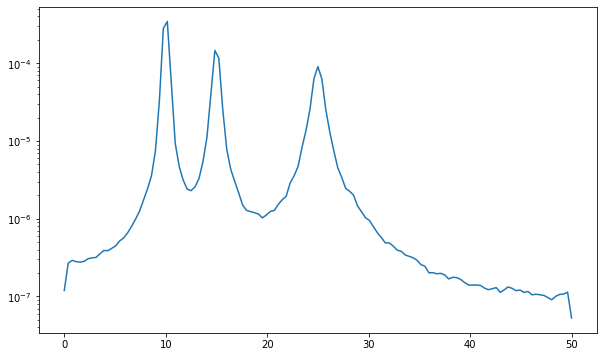

In [6]:
plt.figure(figsize=(10, 6))
plt.semilogy(np.array(fs_list1)[-1], np.array(psd_list1).mean(axis=0))

In [7]:
def PLV(phases):
    complex_signal = np.exp(1j * np.array(phases))
    complex_signal = np.mean(complex_signal, axis=2)
    conj_signal = np.conj(complex_signal)
    mat_dot = complex_signal @ conj_signal.T
    
    N = complex_signal.shape[1]
    return mat_dot / N

plv_result = PLV(phase_list1)  

In [8]:
def func2(freq):
    def inner(ts):
        if 0 <= ts < 15:
            return freq[0]
        if 15 <= ts < 30:
            return freq[1]
        if 30 <= ts < 45:
            return freq[2]
        if 45 <= ts < 60:
            return freq[3]
    return inner

freq_list2 = [[10, 20, 25, 10]]
signal_list2, psd_list2, fs_list2, phase_list2 = simulation(func2, timesteps, dt, freq_list2, K, N, sigma)

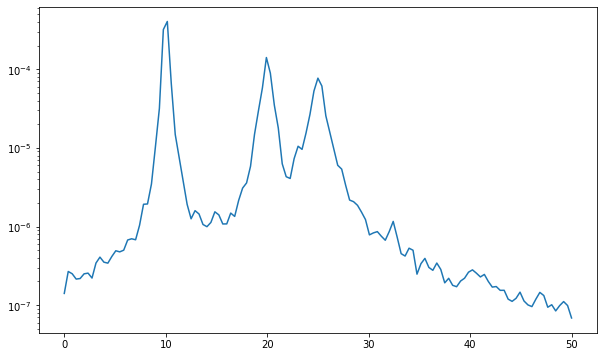

In [10]:
plt.figure(figsize=(10, 6))
plt.semilogy(np.array(fs_list2)[-1], np.array(psd_list2).mean(axis=0))

/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 10, using nperseg = 10
  .format(nperseg, input_length))


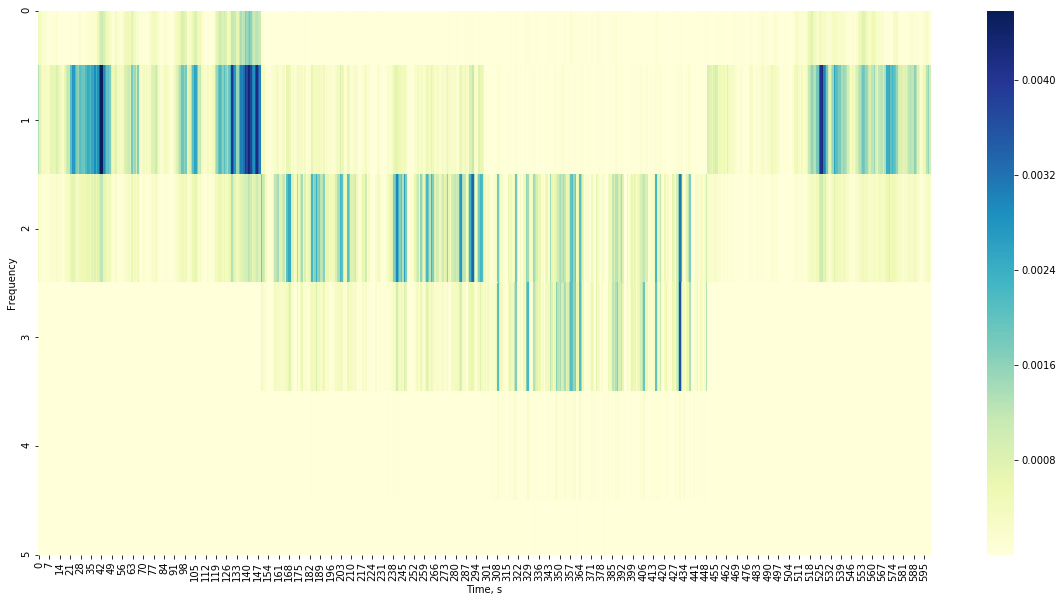

In [12]:
window_size = 10
splited_signal = np.split(signal_list2[0], len(signal_list2[0]) // window_size)
window_num = len(splited_signal)
color_map = []

for s in splited_signal:
    freqs, psd = welch(s, fs=int(1/dt), scaling="spectrum")
    color_map.append(psd)

plt.figure(figsize=(20, 10))
sns.heatmap(np.array(color_map).T, cmap="YlGnBu")
plt.xlabel('Time, s')
plt.ylabel('Frequency')
plt.show()